# RTBP Problem  WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-RTBP">
             Initial value problem: RTBP</a></li>
             
<li><a href="#Test-solution">
             Test solution</a></li>             

<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem:  RTBP

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/RTBP.jl")
include("../ODEProblems/InitialRTBP.jl")


# one period !! !!!

t0=0.0
t1=parse(Float64,"17.0652165601579625588917206249")

u064,μ64 =InitialRTBP(Float64)
lpp=[μ64]
tspan64=(t0,2*t1)
prob64 = ODEProblem(f,u064,tspan64,[μ64]);

u0128,μ128=InitialRTBP(BigFloat)
tspan128=(BigFloat(t0),parse(BigFloat,"17.0652165601579625588917206249"))
prob128 = ODEProblem(f,u0128,tspan128,[μ128]);
(typeof(u064),typeof(μ64),typeof(tspan64),typeof(u0128),typeof(μ128),typeof(tspan128))

(Vector{Float64}, Float64, Tuple{Float64, Float64}, Vector{BigFloat}, BigFloat, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [6]:
#u0256,μ256 =InitialRTBP(BigFloat)
#test_sol = TestSolution(tspan128,[u0128])
#test_sol.u[1]-u0256

#apr = appxtrue(sol,test_sol)
#fieldnames(typeof(apr))
#apr.errors

In [7]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/RTBP_test_sol.jld2" sol

@load "./Data/RTBP_test_sol.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256,μ256 =InitialRTBP(BigFloat)
E0=RTBPEnergy(u0256,μ256)
(Float32(sol.t[end]),Float32(RTBPEnergy(sol.u[end],μ256)/E0.-1))

(17.065216f0, 3.207703f-31)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

### Computations

In [8]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

In [9]:
setups = [
           Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true) 
]
solnames = ["Vern9","IRKGL16-adaptive"]
wp1 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                       save_everystep=false,numruns=10,maxiters=10^9);

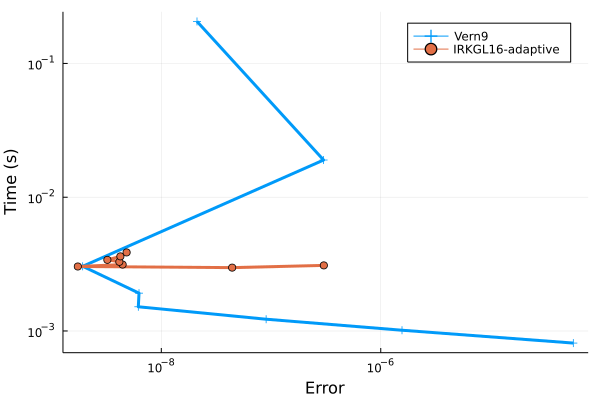

In [10]:
plot(wp1)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [13]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Computations

In [14]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(mixed_precision=false),:adaptive=>true) 
           Dict(:alg=>IRKGL16(mixed_precision=true),:adaptive=>true)
           Dict(:alg=>IRKGL16(mixed_precision=true,threading=true),:adaptive=>true)
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/Mix","IRKGL16-adaptative/Mix/thread"]
wp2 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,
                        names=solnames,numruns=10,maxiters=10^9);

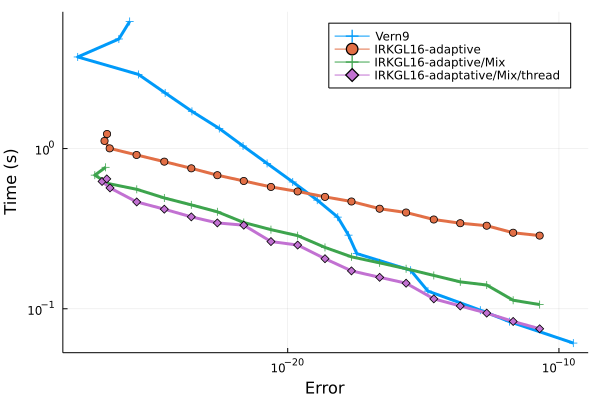

In [15]:
plot(wp2)

### Plot for JuliaCon2020

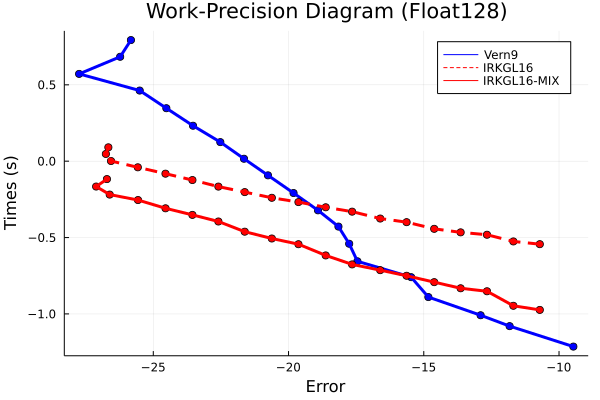

In [17]:
plot(title="Work-Precision Diagram (Float128)", xlabel="Error", ylabel="Times (s)")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="Vern9", color="blue", lw=3)
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16", color="red", lw=3, linestyle=:dash)
#
k=3
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16-MIX",color="red", lw=3)

### Save/Load Data

Load my own experiment's executed data

In [18]:
#@save "./Data/output/OutRTBP_wp1.jld2" wp1
#@save "./Data/output/OutRTBP_wp2.jld2" wp2

In [19]:
#@load "./Data/output/OutRTBP_wp1.jld2" wp1
#@load "./Data/output/OutRTBP_wp2.jld2" wp11

<a href="#top">Back to the top</a>